In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
from pathlib import Path
from lmfit import Parameters
from lmfit import minimize, fit_report

In [2]:
import pyroll.core as pr
import pyroll.pillar_model
import pyroll.neutral_point_estimator
import pyroll.sparling_spreading
import pyroll.hensel_force_torque
import pyroll.freiberg_flow_stress
import pyroll.ring_model_thermal
from pyroll.freiberg_flow_stress import flow_stress

In [3]:
from in_profile import create_in_profile_for_finishing_train
from rolling_sequence import finishing_pass_design_1, finishing_pass_design_2, finishing_pass_design_3
from utilities import *

In [4]:
pyroll.pillar_model.Config.PILLAR_COUNT = 30
pyroll.neutral_point_estimator.Config.ESTIMATOR = "EQUAL"
ROLL_SURFACE_TEMPERATURE = 50 + 273.15
DISK_ELEMENT_COUNT = 30

root_dir = Path.cwd()
result_dir = root_dir / "res"

In [5]:
@pr.CoolingPipe.DiskElement.heat_transfer_coefficient
def heat_transfer_coefficient_model_wehage_8_mm(self: pr.CoolingPipe.DiskElement):
    mean_surface_temperature = (self.in_profile.surface_temperature + self.out_profile.surface_temperature) / 2
    profile_surface_temperature_celsius = mean_surface_temperature - 273.15
    return 13950 + 5.12 * 1e6 / profile_surface_temperature_celsius

In [6]:
in_profile = create_in_profile_for_finishing_train(1000 + 273.15)
in_profile.ring_temperatures = in_profile.ring_temperatures

In [7]:
rolling_train_rpd1 = finishing_pass_design_1(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd2 = finishing_pass_design_2(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)
rolling_train_rpd3 = finishing_pass_design_3(ROLL_SURFACE_TEMPERATURE, DISK_ELEMENT_COUNT)

In [8]:
rolling_train_rpd1.solve(in_profile)
rolling_train_rpd2.solve(in_profile)
rolling_train_rpd3.solve(in_profile)

Solution iteration of TwoRollPass '23-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '24-V' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '17-H' exceeded the maximum iteration count of 100. Continuing anyway.
Solution iteration of TwoRollPass '21-H' exceeded the maximum iteration count of 100. Continuing anyway.


Profile(
    classifiers={'false_round', 'generic_elongation', 'round', 'symmetric'},
    core_temperature=np.float64(1427.6761988519434),
    cross_section=Polygon(
        area=5.82635223011719e-05,
        height=0.008700000000000006,
        perimeter=0.027129052534426306,
        width=0.008249205309779701,
        ),
    length=92.57471047202144,
    material=['BST500', 'steel'],
    ring_temperatures=array([1427.67619885, 1425.12885076, 1417.48364213, 1404.71390799,
           1386.73283377, 1363.43020677, 1334.96919828, 1302.52868241,
           1269.31990663, 1240.94291809, 1223.47281019]),
    strain=np.float64(0.429279759512508),
    surface_temperature=np.float64(1223.4728101860087),
    t=np.float64(1.8404522810135255),
    temperature=np.float64(1300.7235075758595),
    weight=2400,
    width=np.float64(0.008249205309779701),
    )

In [10]:
sequences = [
    {"label": "RPD1", "sequence": rolling_train_rpd1},
    {"label": "RPD2", "sequence": rolling_train_rpd2},
    {"label": "RPD3", "sequence": rolling_train_rpd3}
]

In [11]:
params_constant = Parameters()
params_constant.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_4_pass_block = Parameters()
params_4_pass_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_6_pass_block = Parameters()
params_6_pass_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_csb_block = Parameters()
params_csb_block.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

params_clusters = Parameters()
params_clusters.add('wear_coefficient', value=1e-5, min=1e-20, max=1e-1, vary=True)

In [12]:
result_constant = minimize(
    solve_total_wear_depths_as_contour_line,
    params_constant,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.24721112160247533
RMS error:  2.0456105635131996
RMS error:  5.875349904002905
RMS error:  0.217722478004635
RMS error:  2.0456105635131996
RMS error:  0.0002320375684999548
RMS error:  0.24721112160247533
RMS error:  0.05091958148656438
RMS error:  0.06566459588026798
RMS error:  0.0110608357059894
RMS error:  0.01843342945302313
RMS error:  0.002017660165502334
RMS error:  0.005703967579107708
RMS error:  0.00021765559173702806
RMS error:  0.002017660165502334
RMS error:  2.4308236647014783e-06
RMS error:  0.0002320375684999548
RMS error:  5.1167487820817595e-05
RMS error:  5.835595243308909e-05
RMS error:  1.052016823202153e-05
RMS error:  1.4090917622510025e-05
RMS error:  1.6636686688770098e-06
RMS error:  1.6636686688770098e-06
RMS error:  1.6636686688770098e-06
RMS error:  9.177748805855953e-06
RMS error:  4.177959779413433e-05


In [13]:
print(fit_report(result_constant))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 69
    # variables        = 1
    chi-square         = 1.9098e-10
    reduced chi-square = 2.8085e-12
    Akaike info crit   = -1834.29498
    Bayesian info crit = -1832.06087
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 4.4168e-12 (4.04%) (init = 1e-05)


In [14]:
result_4_pass_block = minimize(
    solve_total_wear_depths_as_contour_line_4_pass_block,
    params_4_pass_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="cobyla"
)

RMS error:  0.2594778790525292
RMS error:  618.3818284514125
RMS error:  574.7152847107088
RMS error:  146.61174415927474
RMS error:  47.00348361986511
RMS error:  7.145262063967255
RMS error:  4.412720335744155
RMS error:  0.08209426115555919
RMS error:  0.4684905672445948
RMS error:  0.007663135019633503
RMS error:  0.00014211181800542183
RMS error:  0.003805330169677989
RMS error:  0.00016643486396573822
RMS error:  0.0005939315258805611
RMS error:  3.22132535226802e-05
RMS error:  8.19132396743146e-07
RMS error:  8.657840778010919e-06
RMS error:  3.735262891937268e-06
RMS error:  3.735262891937268e-06
RMS error:  3.735262891937268e-06
RMS error:  5.0531630317138796e-05
RMS error:  8.657840778010919e-06


In [15]:
print(fit_report(result_4_pass_block))

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 18
    # data points      = 17
    # variables        = 1
    chi-square         = 2.3719e-10
    reduced chi-square = 1.4824e-11
    Akaike info crit   = -422.921540
    Bayesian info crit = -422.088327
[[Variables]]
    wear_coefficient:  1.6322e-10 +/- 2.0925e-11 (12.82%) (init = 1e-05)


In [16]:
result_6_pass_block = minimize(
    solve_total_wear_depths_as_contour_line_6_pass_block,
    params_6_pass_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.28150846606759383
RMS error:  2.3294168014546637
RMS error:  6.690491952484776
RMS error:  0.2479285851933673
RMS error:  2.3294168014546637
RMS error:  0.0002636454319623004
RMS error:  0.28150846606759383
RMS error:  0.057983551739614086
RMS error:  0.07477428086340888
RMS error:  0.012594826703283876
RMS error:  0.020990289837243173
RMS error:  0.0022970060994198086
RMS error:  0.006494749771141751
RMS error:  0.0002472679702770513
RMS error:  0.0022970060994198086
RMS error:  3.1136873871664793e-06
RMS error:  0.0002636454319623004
RMS error:  5.7673821707314606e-05
RMS error:  6.586102643113529e-05
RMS error:  1.1349266924082663e-05
RMS error:  1.542590682561078e-05
RMS error:  1.4680848833652231e-06
RMS error:  1.4680848833652231e-06
RMS error:  1.4680848833652231e-06
RMS error:  9.815051974068189e-06
RMS error:  4.698106257275288e-05


In [17]:
print(fit_report(result_6_pass_block))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 36
    # variables        = 1
    chi-square         = 7.7590e-11
    reduced chi-square = 2.2169e-12
    Akaike info crit   = -965.071730
    Bayesian info crit = -963.488211
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 4.8391e-12 (4.43%) (init = 1e-05)


In [56]:
result_csb_block = minimize(
    solve_total_wear_depths_as_contour_line_csb_block,
    params_csb_block,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

RMS error:  0.11708402121856896
RMS error:  0.9688436424548538
RMS error:  2.782688361306398
RMS error:  0.10311758233079375
RMS error:  0.9688436424548538
RMS error:  0.0001095597321637211
RMS error:  0.11708402121856896
RMS error:  0.024116238893997458
RMS error:  0.0310997863633322
RMS error:  0.005238302570073875
RMS error:  0.008730117280787892
RMS error:  0.0009552655294692582
RMS error:  0.002701177730258143
RMS error:  0.00010274830567710392
RMS error:  0.0009552655294692582
RMS error:  1.6652785600337832e-06
RMS error:  0.0001095597321637211
RMS error:  2.3904746882208688e-05
RMS error:  2.7308024375696513e-05
RMS error:  4.698762020846232e-06
RMS error:  6.37350562372157e-06
RMS error:  1.0264031036608817e-06
RMS error:  1.0264031036608817e-06
RMS error:  1.0264031036608817e-06
RMS error:  4.072288788047709e-06
RMS error:  1.9460937029710873e-05


In [57]:
print(fit_report(result_csb_block))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 16
    # variables        = 1
    chi-square         = 1.6856e-11
    reduced chi-square = 1.1237e-12
    Akaike info crit   = -439.262400
    Bayesian info crit = -438.489811
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 1.2497e-11 (11.43%) (init = 1e-05)


In [20]:
result_clusters = minimize(
    solve_total_wear_depths_as_contour_line_4_and_6_pass_block,
    params_clusters,
    nan_policy='omit',
    max_nfev=100,
    args=(sequences,),
    method="nelder"
)

In [21]:
print(fit_report(result_clusters))

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 22
    # data points      = 53
    # variables        = 1
    chi-square         = 1.7412e-10
    reduced chi-square = 3.3485e-12
    Akaike info crit   = -1399.40260
    Bayesian info crit = -1397.43231
[[Variables]]
    wear_coefficient:  1.0929e-10 +/- 4.9480e-12 (4.53%) (init = 1e-05)


In [39]:
measured_wear_area_constant = []
calculated_wear_area_constant = []

measured_wear_area_4_pass = []
calculated_wear_area_4_pass = []

measured_wear_area_6_pass = []
calculated_wear_area_6_pass = []

measured_wear_area_csb = []
calculated_wear_area_csb = []

measured_wear_area_4_and_6_pass = []
calculated_wear_area_4_and_6_pass = []

In [40]:
for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    calculated_wear_contour = calculate_wear_contour(roll_pass, result_constant.params['wear_coefficient'].value, tonnage * 1000)
                    calculated_wear_area_constant.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                    measured_wear_area_constant.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    if roll_pass.label in ["17-H", "18-V"]:
                        calculated_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["21-H", "22-V", "23-H", "24-V"]:
                         calculated_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))
                    elif roll_pass.label in ["27-H", "28-V"]:
                         calculated_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                         measured_wear_area_csb.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))

for entry in sequences:
    groove_label = entry["label"]
    sequence = entry["sequence"]
    roll_passes = sequence.roll_passes
    measurements = extract_wear_contours_from_measurement(groove_label)
    for measurement_id, labels, tonnages, measured_wear_contours in measurements:
        for roll_pass in roll_passes:
            for label, tonnage, measured_wear_contour in zip(labels, tonnages, measured_wear_contours):
                if roll_pass.label == label:
                    if roll_pass.label in ["17-H", "18-V", "21-H", "22-V", "23-H", "24-V"]:
                        calculated_wear_contour = calculate_wear_contour(roll_pass, result_clusters.params['wear_coefficient'].value, tonnage * 1000)
                        calculated_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, calculated_wear_contour))
                        measured_wear_area_4_and_6_pass.append(calculate_area_between_contours(roll_pass.roll.contour_line, measured_wear_contour))


NameError: name 'np' is not defined

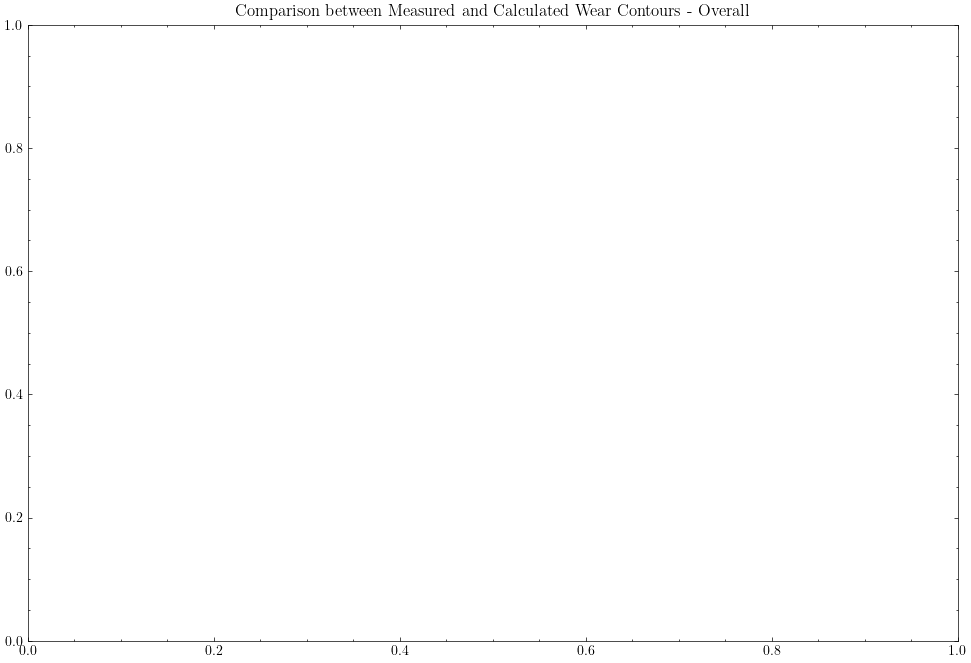

In [2]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Overall")
ax.scatter(np.array(measured_wear_area_constant) * 1e6, np.array(calculated_wear_area_constant) * 1e6, color='C0', alpha=0.5)
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]", fontsize=10)
ax.set_xlabel("Measured [mm²]", fontsize=10)

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_overall.pdf", bbox_inches='tight', dpi=300)

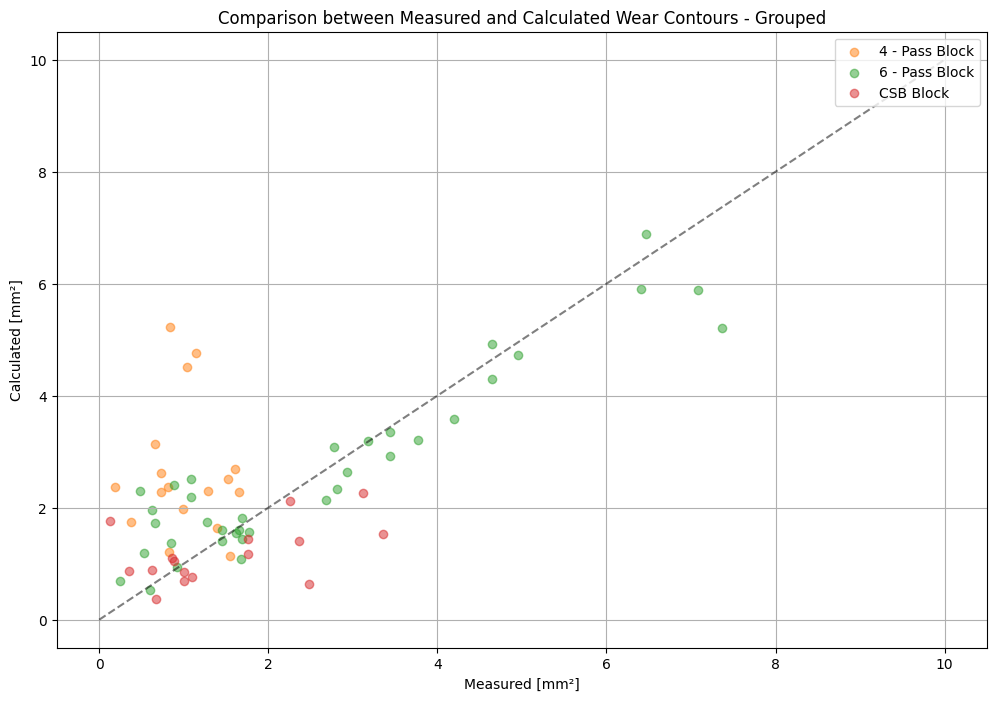

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Grouped")
ax.scatter(np.array(measured_wear_area_4_pass) * 1e6, np.array(calculated_wear_area_4_pass) * 1e6, color='C1', alpha=0.5, label="4 - Pass Block")
ax.scatter(np.array(measured_wear_area_6_pass) * 1e6, np.array(calculated_wear_area_6_pass) * 1e6, color='C2', alpha=0.5, label="6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_per_block.pdf", bbox_inches='tight', dpi=300)

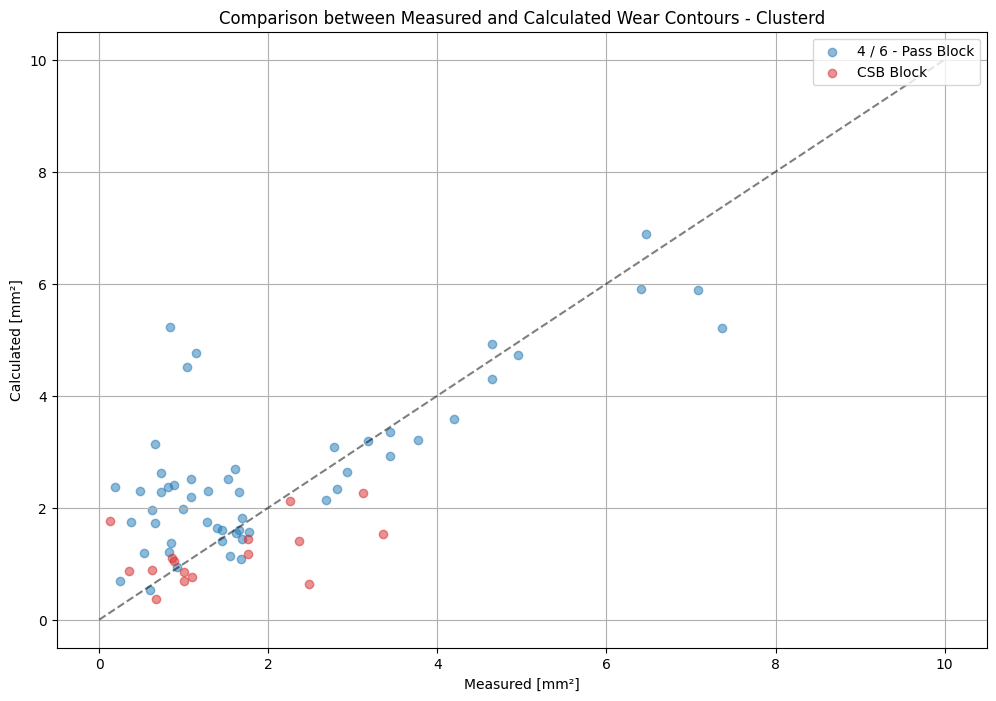

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Comparison between Measured and Calculated Wear Contours - Clusterd")
ax.scatter(np.array(measured_wear_area_4_and_6_pass) * 1e6, np.array(calculated_wear_area_4_and_6_pass) * 1e6, color='C0', alpha=0.5, label="4 / 6 - Pass Block")
ax.scatter(np.array(measured_wear_area_csb) * 1e6, np.array(calculated_wear_area_csb) * 1e6, color='C3', alpha=0.5, label="CSB Block")
ax.plot(np.linspace(0, 10, 10), np.linspace(0, 10, 10), alpha=0.5, ls='--', color='black')
ax.grid()
ax.set_ylabel("Calculated [mm²]")
ax.set_xlabel("Measured [mm²]")

handels, labels = ax.get_legend_handles_labels()
unique_legends = dict(zip(labels, handels))
ax.legend(
    unique_legends.values(), unique_legends.keys(),
    loc="upper right"
)

fig.savefig(result_dir / "fitting_results_for_clustering.pdf", bbox_inches='tight', dpi=300)